In [3]:
import os
import numpy as np

import torch
import torchaudio
from torch.utils.data import DataLoader
import librosa

from SpecRNet.model import SpecRNet
from SpecRNet import config
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(
            self,
            root_dir,
            transform=None
    ):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.data = []

        for label in range(len(self.classes)):

            class_folder = f'{root_dir}{self.classes[label]}' 
   
            for filename in os.listdir(class_folder):
                data_path = f'{class_folder}/{filename}'
                self.data.append((data_path, label))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):

        data_path, label = self.data[idx]

        data = torch.load(data_path)
        
        if self.transform:
            data = self.transform(data)
            
        return data, label

In [3]:
root_dir_T = 'KSS/LFCC(TTS)'

dataset = CustomDataset(root_dir_T)

In [4]:
root_dir_F = 'KSS/LFCC(GAN)'

dataset = CustomDataset(root_dir_F)

In [5]:
val_len = int(len(dataset) * 0.15)
test_len = int(len(dataset) * 0.15)
train_len = len(dataset) - (val_len) - (test_len)
lengths = [train_len, val_len, test_len]

train, val, test = torch.utils.data.random_split(dataset, lengths)

In [6]:
batch_size = 128

In [7]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

In [8]:
device = 'cuda'
specrnet_config = {
        "filts": [1, [1, 20], [20, 64], [64, 64]],
        "nb_fc_node": 64,
        "gru_node": 64,
        "nb_gru_layer": 2,
        "nb_classes": 1,
    }

In [ ]:
model = SpecRNet(specrnet_config, device='cuda').to('cuda')

In [ ]:
criterion = torch.nn.BCEWithLogitsLoss().to('cuda')
optim = torch.optim.Adam(model.parameters(),lr = 0.0001, weight_decay = 0.0001,)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.loss = np.inf
        self.patience = 0
        self.patience_limit = patience

    def step(self, loss):
        if self.loss > loss:
            self.loss = loss
            self.patience = 0
        else:
            self.patience += 1

    def is_stop(self):
        return self.patience >= self.patience_limit

early_stop = EarlyStopping(patience=5)

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.1, patience=5, verbose=True)

In [ ]:
best_model = None
best_acc = 0
best_loss = np.inf
n_epochs = 15

for epoch in range(1, n_epochs+1):

    train_loss = 0.0
    correct = 0
    total = 0

    model.train()

    for batch_x, batch_y in train_loader:

        batch_size = batch_x.size(0)
        total += batch_size

        batch_x = batch_x.to(device)
        batch_y = batch_y.unsqueeze(1).type(torch.float32).to(device)

        batch_out = model(batch_x)
        batch_loss = criterion(batch_out, batch_y)

        batch_pred = (torch.sigmoid(batch_out) + .5).int()
        correct += (batch_pred == batch_y.int()).sum(dim=0).item()

        train_loss += (batch_loss.item() * batch_size)
        optim.zero_grad()
        batch_loss.backward()
        optim.step()

    train_loss /= total
    train_acc = (correct/total)*100

    print(f"[{epoch:04d}]: train loss: {train_loss} - train acc: {train_acc}")

    val_loss = 0.0
    val_correct = 0
    val_total = 0
    model.eval()
    with torch.no_grad():
        for batch_x, batch_y in val_loader:

            batch_size = batch_x.size(0)
            val_total += batch_size

            batch_x = batch_x.to(device)
            batch_y = batch_y.unsqueeze(1).type(torch.float32).to(device)

            batch_out = model(batch_x)
            val_loss = criterion(batch_out, batch_y)
            batch_pred = (torch.sigmoid(batch_out) + .5).int()
            val_correct += (batch_pred == batch_y.int()).sum(dim=0).item()

            val_loss += (batch_loss.item() * batch_size)

    val_loss /= len(val_loader.dataset)
    val_acc = 100 * (val_correct / val_total)
    print(f'val Loss: {val_loss} \t val Acc: {val_acc}%')

    scheduler.step(val_loss)

    if val_loss < best_loss:
        print('Improve, Save Model')
        torch.save(model.state_dict(), 'model.pth')
        best_loss = val_loss

In [ ]:
dataset.data

In [ ]:
model.to('cpu')
model.eval

all_predictions = []
all_labels = []

# 데이터 로더를 통해 데이터와 레이블을 순차적으로 처리
with torch.no_grad():
    for data, labels in test_loader:
        # 데이터를 모델에 입력하여 예측을 수행
        data = data.to('cpu')
        labels = labels.unsqueeze(1).type(torch.float32).to('cpu')
        
        outputs = model(data)
        
        # 이진 분류: 출력을 0 또는 1로 변환 (sigmoid 함수 적용 후 0.5 기준으로 분류)
        predicted = (outputs > 0.5).long()
        
        # 예측 결과와 레이블을 리스트에 추가
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# F1 스코어 계산
f1 = f1_score(all_labels, all_predictions)

# F1 스코어 출력
print("F1 Score:", f1)

## 혼동행렬

TTS_Model_GAN Confusion Matrix:
[[1924    0]
 [  14 1897]]


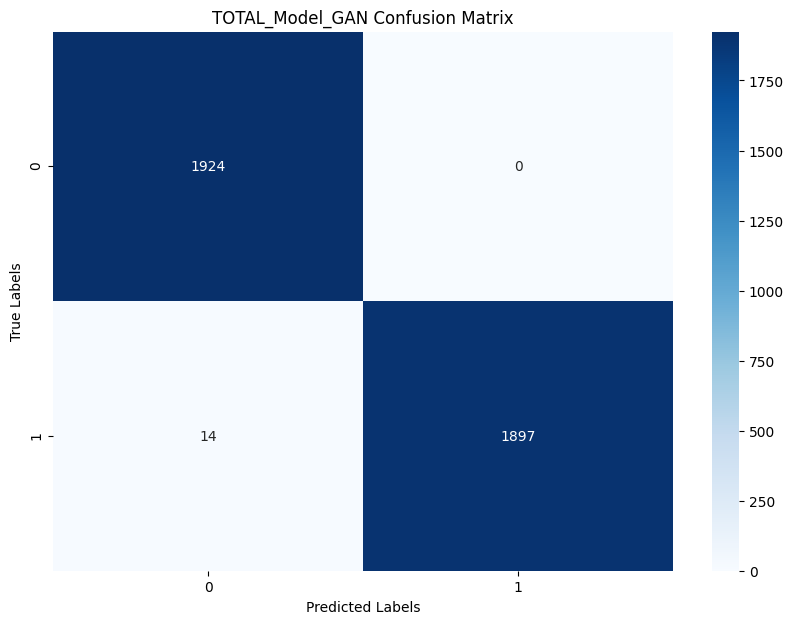

In [ ]:
all_preds = []
all_labels = []

with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to('cpu'), labels.to('cpu')
        outputs = model(data)
        predicted = (outputs > 0.5).long()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
print("TTS_Model_GAN Confusion Matrix:")
print(cm)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('TOTAL_Model_GAN Confusion Matrix')
plt.show()

Confusion Matrix:
[[1403  489]
 [ 284 1659]]


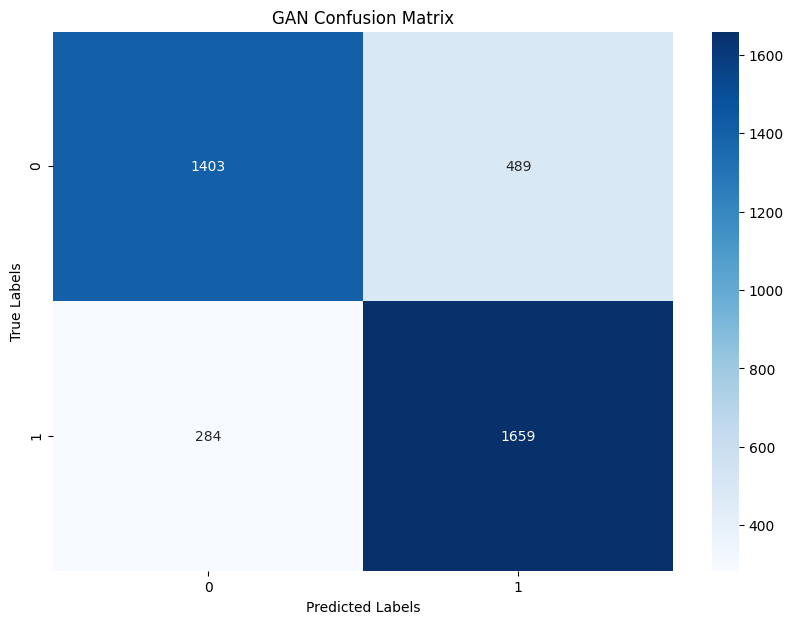

In [ ]:
model = model_F

all_preds = []
all_labels = []

with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to('cpu'), labels.to('cpu')
        outputs = model(data)
        #_, preds = torch.max(outputs, 1)#(모델예측결과,차원)텐서의 index, 최대값
        predicted = (outputs > 0.5).long()
        all_preds.extend(predicted.cpu().numpy())#CPU()텐서를 CPU로
        all_labels.extend(labels.cpu().numpy())#extend = 모든 요소를 추가

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

#TP FN : TP(1 정답 수), FN(1 을 2로 분류한 경우)
#FP TN : FP(2 를 1로 분류한 경우), TN(2 정답 수)

#혼동행렬 시각화
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('GAN Confusion Matrix')
plt.show()

In [ ]:
torch.save(model.state_dict(), 'TTS_model.pth')

EVAL

In [8]:
ckpt_F = torch.load('D:/UMMAFormer/GAN_model.pth')
ckpt_T = torch.load('D:/UMMAFormer/TTS_model.pth')
ckpt_TT = torch.load('D:/UMMAFormer/TOTAL_model.pth')
ckpt_CX = torch.load('D:/UMMAFormer/CLPX_model.pth')


In [9]:
specrnet_config = config.get_specrnet_config(input_channels=1)

model_CX = SpecRNet(specrnet_config, device='cpu')
model_CX.load_state_dict(ckpt_CX)

<All keys matched successfully>

In [10]:
specrnet_config = config.get_specrnet_config(input_channels=1)

model_TT = SpecRNet(specrnet_config, device='cpu')
model_TT.load_state_dict(ckpt_TT)

<All keys matched successfully>

In [36]:
specrnet_config = config.get_specrnet_config(input_channels=1)

GAN = SpecRNet(specrnet_config, device='cpu')
GAN.load_state_dict(ckpt_F)

<All keys matched successfully>

In [37]:
specrnet_config = config.get_specrnet_config(input_channels=1)

TTS = SpecRNet(specrnet_config, device='cpu')
TTS.load_state_dict(ckpt_T)

<All keys matched successfully>

Visualize

In [13]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
input_24_R = torch.load('D:/UMMAFormer/WavDATA/Visual/1_0101.pt')
input_24_F = torch.load('D:/UMMAFormer/WavDATA/Visual/1_0101_gen.pt')

In [14]:
input = torch.load('D:/UMMAFormer/WavDATA/th/th_6.pt')

In [ ]:
gan_out = model_F(input.unsqueeze(0))
tts_out = model_T(input.unsqueeze(0))
CX_out = model_CX(input.unsqueeze(0))
TT_out = model_TT(input.unsqueeze(0))
print(gan_out, tts_out, TT_out, CX_out)

In [100]:
pred_gan = (gan_out > 0.5).long()
pred_tts = (tts_out > 0.5).long()
pred_TT = (TT_out > 0.5).long()
pred_CX = (CX_out > 0.5).long()
print(pred_gan, pred_tts, pred_TT, pred_CX)

tensor([[1]]) tensor([[1]]) tensor([[1]]) tensor([[0]])


In [78]:
gan_out_r = model_F(in_r.unsqueeze(0))
tts_out_r = model_T(in_r.unsqueeze(0))
CX_out_r = model_CX(in_r.unsqueeze(0))
TT_out_r = model_TT(in_r.unsqueeze(0))
gan_out_f = model_F(in_f.unsqueeze(0))
tts_out_f = model_T(in_f.unsqueeze(0))
CX_out_f = model_CX(in_f.unsqueeze(0))
TT_out_f = model_TT(in_f.unsqueeze(0))

In [86]:
print(gan_out_r, tts_out_r, TT_out_r, CX_out_r)

tensor([[4.5270]], grad_fn=<AddmmBackward0>) tensor([[2.2506]], grad_fn=<AddmmBackward0>) tensor([[-1.3757]], grad_fn=<AddmmBackward0>) tensor([[-5.6537]], grad_fn=<AddmmBackward0>)


In [87]:
print(gan_out_f, tts_out_f, TT_out_f, CX_out_f)

tensor([[4.7905]], grad_fn=<AddmmBackward0>) tensor([[3.7598]], grad_fn=<AddmmBackward0>) tensor([[-0.5143]], grad_fn=<AddmmBackward0>) tensor([[-6.2235]], grad_fn=<AddmmBackward0>)


In [79]:
pred_gan = (gan_out_r > 0.5).long()
pred_tts = (tts_out_r > 0.5).long()
pred_TT = (TT_out_r > 0.5).long()
pred_CX = (CX_out_r > 0.5).long()

In [84]:
pred_gan_f = (gan_out_f > 0.5).long()
pred_tts_f = (tts_out_f > 0.5).long()
pred_TT_f = (TT_out_f > 0.5).long()
pred_CX_f = (CX_out_f > 0.5).long()

In [82]:
print(pred_gan, pred_tts, pred_TT, pred_CX)

tensor([[1]]) tensor([[1]]) tensor([[0]]) tensor([[0]])


In [85]:
print(pred_gan_f, pred_tts_f, pred_TT_f, pred_CX_f)

tensor([[1]]) tensor([[1]]) tensor([[0]]) tensor([[0]])


In [76]:
in_r = torch.load('D:/UMMAFormer/WavDATA/REALvoice.pt')
in_f = torch.load('D:/UMMAFormer/WavDATA/FAKEvoice.pt')

In [62]:
rec = torch.load('D:/UMMAFormer/WavDATA/REC.pt')

In [47]:
gan_percentage = gan_out.item() * 100
tts_percentage = tts_out.item() * 100
CX_percentage = CX_out.item() * 100
TT_percentage = TT_out.item() * 100

In [61]:
print(gan_percentage, tts_percentage, CX_percentage, TT_percentage)

491.03474617004395 -9.644091129302979 -285.9515905380249 53.09186577796936


In [8]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

In [15]:
input_R = torch.load('LFCC/REAL/2_0534.pt')
input_F = torch.load('LFCC/FAKE/2_0534_gen.pt')
input_T = torch.load('LFCC/FAKE/2_0534_tts.pt')

In [16]:
from pytorch_grad_cam import GradCAM, ScoreCAM, XGradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [17]:
layer_F = model_F.block0
layer_T = model_T.block2

In [18]:
grad = GradCAM(model=model_F, target_layers=[layer_F])
scor = ScoreCAM(model=model_F, target_layers=[layer_F])
xgrad = XGradCAM(model=model_F, target_layers=[layer_F])

In [19]:
grad_T = GradCAM(model=model_T, target_layers=[layer_T])
scor_T = ScoreCAM(model=model_T, target_layers=[layer_T])
xgrad_T = XGradCAM(model=model_T, target_layers=[layer_T])

In [20]:
grad.batch_size = 1
scor.batch_size = 1
xgrad.batch_size = 1
grad_T.batch_size = 1
scor_T.batch_size = 1
xgrad_T.batch_size = 1

In [28]:
input_R = torch.load(f'D:/UMMAFormer/WavDATA/TOTAL/LFCC/REAL/4_0534.pt')
input_F = torch.load(f'D:/UMMAFormer/WavDATA/TOTAL/LFCC/FAKE/4_0534_gen.pt')
input_T = torch.load(f'D:/UMMAFormer/WavDATA/TOTAL/LFCC/FAKE/4_0534_tts.pt')


xgrad_cam_F = xgrad(input_tensor=input_F.unsqueeze(0), targets=[ClassifierOutputTarget(0)])
xgrad_cam_F = xgrad_cam_F[0, :]

xgrad_cam_R = xgrad(input_tensor=input_R.unsqueeze(0), targets=[ClassifierOutputTarget(0)])
xgrad_cam_R = xgrad_cam_R[0, :]

xgrad_cam_T = xgrad_T(input_tensor=input_T.unsqueeze(0), targets=[ClassifierOutputTarget(0)])
xgrad_cam_T = xgrad_cam_T[0, :]

In [29]:

grad_cam_F = grad(input_tensor=input_F.unsqueeze(0), targets=[ClassifierOutputTarget(0)])
scor_cam_F = scor(input_tensor=input_F.unsqueeze(0), targets=[ClassifierOutputTarget(0)])
xgrad_cam_F = xgrad(input_tensor=input_F.unsqueeze(0), targets=[ClassifierOutputTarget(0)])
grad_cam_F = grad_cam_F[0, :]
scor_cam_F = scor_cam_F[0, :]
xgrad_cam_F = xgrad_cam_F[0, :]

100%|██████████| 20/20 [00:00<00:00, 99.46it/s]


In [30]:
grad_cam_R = grad(input_tensor=input_R.unsqueeze(0), targets=[ClassifierOutputTarget(0)])
scor_cam_R = scor(input_tensor=input_R.unsqueeze(0), targets=[ClassifierOutputTarget(0)])
xgrad_cam_R = xgrad(input_tensor=input_R.unsqueeze(0), targets=[ClassifierOutputTarget(0)])
grad_cam_R = grad_cam_R[0, :]
scor_cam_R = scor_cam_R[0, :]
xgrad_cam_R = xgrad_cam_R[0, :]

100%|██████████| 20/20 [00:00<00:00, 91.84it/s]


In [31]:
grad_cam_T = grad_T(input_tensor=input_T.unsqueeze(0), targets=[ClassifierOutputTarget(0)])
scor_cam_T = scor_T(input_tensor=input_T.unsqueeze(0), targets=[ClassifierOutputTarget(0)])
xgrad_cam_T = xgrad_T(input_tensor=input_T.unsqueeze(0), targets=[ClassifierOutputTarget(0)])
grad_cam_T = grad_cam_T[0, :]
scor_cam_T = scor_cam_T[0, :]
xgrad_cam_T = xgrad_cam_T[0, :]

100%|██████████| 64/64 [00:00<00:00, 92.83it/s]


In [32]:
def plot_lfcc(lfcc_R,lfcc_F,lfcc_T,cam_R=xgrad_cam_R, cam_F=xgrad_cam_F, cam_T=xgrad_cam_T):
    plt.figure(figsize=(10, 12))

    #REAL
    plt.subplot(3, 1, 1)
    ax_R = plt.gca()
    im_R = ax_R.imshow(lfcc_R, aspect='auto', origin='lower', vmin=-35, vmax=45, cmap=sns.diverging_palette(220, 20, l=40, s=120, as_cmap=True))
    plt.colorbar(im_R, format='%+0.0f ')
    
    cam_R = np.where( cam_R > 0, cam_R, np.nan)
    plt.title('REAL')
    plt.xlabel('Time')
    plt.ylabel('LFCC')
    plt.imshow(cam_R.squeeze(), aspect='auto', origin='lower', alpha=1, vmin=-0.1, vmax=1, cmap='inferno')
    
    #FAKE
    plt.subplot(3, 1, 2)
    ax_F = plt.gca()
    im_F = ax_F.imshow(lfcc_F, aspect='auto', origin='lower', vmin=-35, vmax=45, cmap=sns.diverging_palette(220, 20, l=40, s=120, as_cmap=True))
    plt.colorbar(im_F, format='%+0.0f ')

    plt.title('FAKE')
    plt.xlabel('Time')
    plt.ylabel('LFCC')
    cam_F = np.where( cam_F > 0, cam_F, np.nan)
    plt.imshow(cam_F.squeeze(), aspect='auto', origin='lower', alpha=1, vmin=-0.1, vmax=1, cmap='inferno' )
    
    #TTS
    plt.subplot(3, 1, 3)
    ax_T = plt.gca()
    im_T = ax_T.imshow(lfcc_T, aspect='auto', origin='lower', vmin=-35, vmax=45, cmap=sns.diverging_palette(220, 20, l=40, s=120, as_cmap=True))
    plt.colorbar(im_T, format='%+0.0f')
    
    plt.title('TTS')
    plt.xlabel('Time')
    plt.ylabel('LFCC')
    cam_T = np.where( cam_T > 0, cam_T, np.nan)
    plt.imshow(cam_T.squeeze(), aspect='auto', origin='lower', alpha=1, vmin= -0.1, vmax= 1, cmap='inferno')
    
    plt.tight_layout() 
    #plt.show()

    plt.savefig(f'plt.png',dpi=300,bbox_inches='tight')


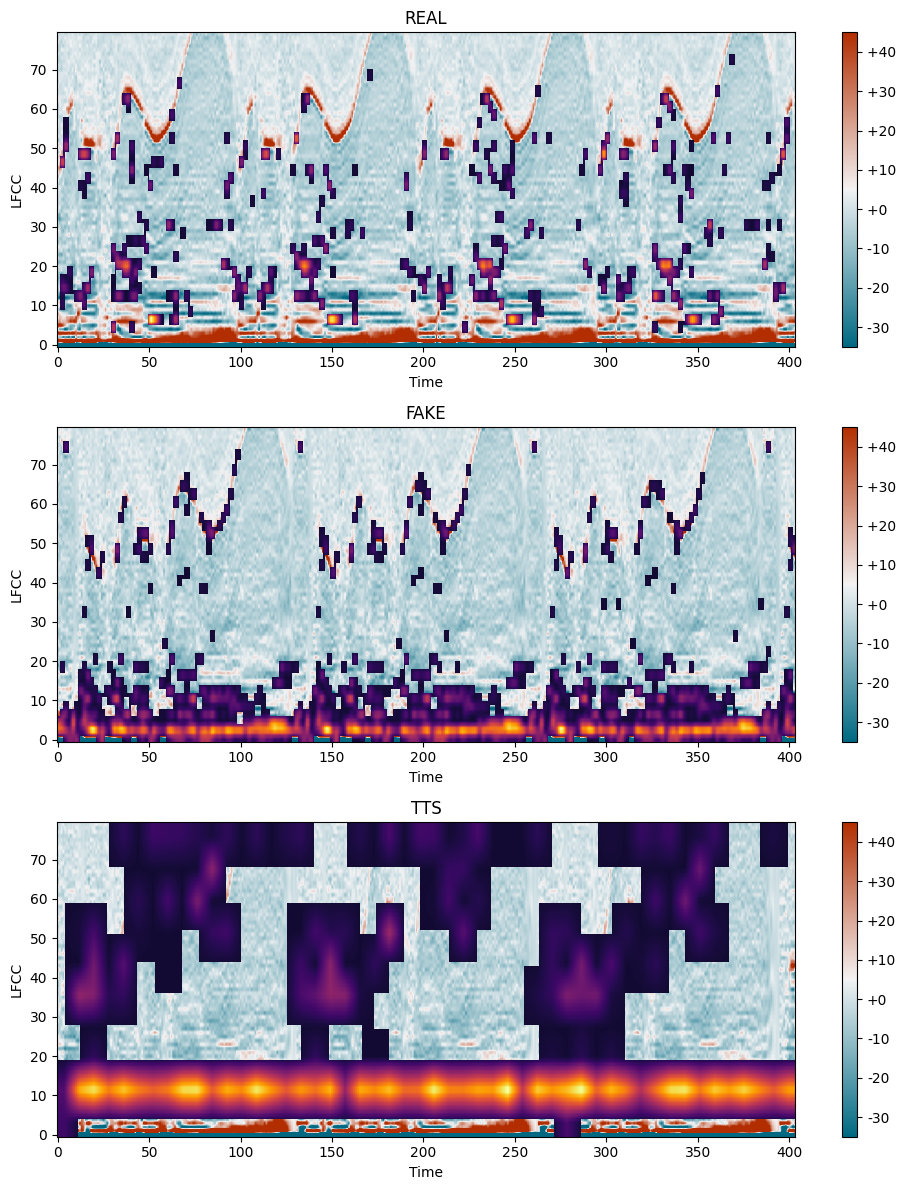

In [33]:
plot_lfcc(input_R.squeeze(),input_F.squeeze(),input_T.squeeze(),cam_R=xgrad_cam_R, cam_F=xgrad_cam_F, cam_T=xgrad_cam_T)

In [34]:
def save_plot(lfcc, cam, output, dpi=600):
    #matplotlib.use('Agg')
    plt.figure(figsize=(10, 4))
    ax = plt.gca()
    im = ax.imshow(lfcc.squeeze(), aspect='auto', origin='lower', vmin=-35, vmax=45, cmap=sns.diverging_palette(220, 20, l=40, s=120, as_cmap=True))
    plt.colorbar(im, format='%+0.4f')
    
    plt.title(output)
    plt.xlabel('Time')
    plt.ylabel('LFCC')
    cam = np.where( cam > 0, cam, np.nan)
    plt.imshow(cam.squeeze(), aspect='auto', origin='lower', alpha=1, vmin= -0.1, vmax= 1, cmap='inferno')
    
    plt.tight_layout()
    plt.show()

    #png_name = f'Audio_xai.png'
    
    #plt.savefig(root+"/"+png_name, dpi=dpi, bbox_inches='tight')
    plt.close()

    #return png_name

In [43]:
def LFCC_pred(input):

    GAN.eval()
    TTS.eval()

    gan_out = GAN(input.unsqueeze(0))
    tts_out = TTS(input.unsqueeze(0))

    gan_sig = torch.sigmoid(gan_out)
    tts_sig = torch.sigmoid(tts_out)

    gan_dct = (gan_sig > 0.5).long()
    tts_dct = (tts_sig > 0.5).long()

    return gan_sig.item(), tts_sig.item(), gan_dct.item(), tts_dct.item(), GAN, TTS


In [46]:
def XAI_GAN(input_G,GAN):

    layer_G = GAN.block0

    xgrad_G = XGradCAM(model=GAN, target_layers=[layer_G])

    xgrad_G.batch_size = 1

    xgrad_cam_G = xgrad_G(input_tensor=input_G.unsqueeze(0), targets=[ClassifierOutputTarget(0)])
    xgrad_cam_G = xgrad_cam_G[0, :]

    return xgrad_cam_G

In [48]:
gan_sig, tts_sig, gan_dct, tts_dct, GAN, TTS = LFCC_pred(input_F)

In [51]:
gan_dct

0

In [40]:
xgrad_cam = XAI_GAN(input_F, GAN)

In [52]:
gan_percentage = gan_sig * 100 

In [56]:
gan_out = f'GAN : {73.00}%'

In [ ]:
save_plot(input_F, xgrad_cam_F,gan_out)